# Reddit Sentiment Analyzer

### An NLP + LSTM based sentiment classifier trained on Reddit posts to predict positive, negative, or neutral sentiment.

The project aims to:
- Classify comments into positive, negative, or neutral sentiment categories.
- Understand how users express opinions across different Reddit posts and topics.
- Generate insights that can support brand monitoring, community management, and decision-making.
- Build a reusable sentiment analysis pipeline that can be applied to other social media datasets as well.

# 1. Data Collection

In [ ]:
# Libraries
import praw
import pandas as pd

### 1. Methods for data collection

In [12]:
# Function to fetch Reddit data
def fetch_reddit_data(reddit,subreddit_name, limit=100, sort='hot'):
    # Access subreddit
    subreddit = reddit.subreddit(subreddit_name)

    posts = []

    # Select sorting
    if sort == "new":
        submissions = subreddit.new(limit=limit)
    elif sort == "hot":
        submissions = subreddit.hot(limit=limit)
    elif sort == "top":
        submissions = subreddit.top(limit=limit)
    else:
        raise ValueError("Invalid sort method. Choose from 'new', 'hot', 'top'.")

    for submission in submissions:
        comments = []
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
          comments.append({
                  "comment_id": comment.id,
                  "parent_id": comment.parent_id,
                  "comment_text": comment.body,
                  "comment_score": comment.score,
                  "comment_created_utc": comment.created_utc
          })
        posts.append(
            {
              "post_id": submission.id,
              "title": submission.title,
              "content": submission.selftext,
              "author": submission.author,
              "score": submission.score,
              "num_comments": submission.num_comments,
              "created_utc": submission.created_utc,
              "comments": comments
            }
        )
    return posts

### 2. Reddit API

In [176]:
# Connect Reddit API
# You can get it https://www.reddit.com/prefs/apps

reddit = praw.Reddit(
    client_id='CLIENT_ID',
    client_secret='CLIENT_SECRET',
    user_agent='USER_AGENT'
)

### 3. Data collection

In [15]:
# Fetching Reddit data into  Pandas Dataframe
posts = fetch_reddit_data(reddit,"samsung" )
data = pd.DataFrame(posts)
data.to_csv("reddit_posts.csv", index=False)
data.head()


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

,post_id,title,content,author,score,num_comments,created_utc,comments
0,1m961aw,"The Fold7, Flip7, Watch8 and Watch Ultra Are N...",[Starting today](https://news.samsung.com/us/s...,dahliamma,38,36,1.753466e+09,"[{'comment_id': 'n54lp89', 'parent_id': 't3_1m..."
1,1m011qy,Fold7 and Watch8 Classic Impressions and AMA,I've been using the Fold7 and Watch8 Classic f...,dahliamma,63,80,1.752533e+09,"[{'comment_id': 'n35yv71', 'parent_id': 't3_1m..."
2,1mtyiqg,"A month in with the Z Flip7, I gotta say man.....",Samsung did a lot of good with this phone. Lik...,yayoshorti,277,97,1.755551e+09,"[{'comment_id': 'n9fbjiv', 'parent_id': 't3_1m..."
3,1mtmxj5,Samsung Introduces Galaxy Buds3 FE With Iconic...,,MishaalRahman,52,37,1.755526e+09,"[{'comment_id': 'n9d3p1w', 'parent_id': 't3_1m..."
4,1mtrift,"114"" Neo QLED 4K QN90F 2 new Now Available $26...",,Stephancevallos905,28,16,1.755536e+09,"[{'comment_id': 'n9dnwd8', 'parent_id': 't3_1m..."


### 4. Filter Required data

In [41]:
# Selecting required Data from dataset
comments = []
for post in data['comments']:
  if post:
    for i in range(len(post)):
      comments.append(post[i]['comment_text'])

df = pd.DataFrame({'text': comments})
df.to_csv("comments.csv", index=False)
df.head()


,text
0,https://preview.redd.it/3zz5o05y72ff1.jpeg?wid...
1,Just wanted to say that these aren't affiliate...
2,https://preview.redd.it/k5kchcca15ff1.jpeg?wid...
3,i love the watch8 and the flip7 so much. might...
4,Damn I wish I didn’t upgrade to a 16 pro max i...


# 2. Preprocessing

In [43]:
# Libraries
import re
import string
import nltk
import emoji

from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 1. Methods for preprocessing

In [44]:
# FUNCTIONS FOR PREPROCESS

# Clean text
def clean_text(text):
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r"http[s]?://\S+|www\.\S+", "<url>", text) # replace url
    text = re.sub(r"[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}", "<email>", text) # repalce email
    text = re.sub(r'@\w+', '<username>', text) # replace username
    text = re.sub(r'#', '<hastag>', text) # replace hastag
    text = re.sub(r"\d+", "<num>", text) # replace number
    text = re.sub(r"\n+", " ", text) # remove newline character
    text = re.sub(r'[^\w\s<>]', ' ', text)  # replace punctation
    return text

# Encode label from values to String
def get_sent_label(label):
    if label == 0:
      return "Negative"
    if label == 1:
      return "Positive"
    if label == 2:
      return "Neutral"

# Get dummy labels using nltk sentiment vader
def get_sent_value(text, sia):
    # sia: sentiment intensity analyzer
    score = sia.polarity_scores(text)['compound']
    if score <= -0.05:
      return 0 #Negative
    elif score >= 0.05:
      return 1 #Positive
    else:
      return 2 #Neutral

# Preprocess the data by adding `label` column and `cleaned text` column
# df: Pandas DataFrame
# sia: Sentiment intensity analyzer of nltk vader
def preprocess(df, sia):
    df.loc[:,'label'] =  df['text'].apply(lambda x : get_sent_value(x, sia))
    df.loc[:,'cleaned_text'] = df['text'].apply(clean_text)
    return df

### 2. Preprocessing

In [45]:
# Preprocess the data

sia = SentimentIntensityAnalyzer()
df = preprocess(df, sia)
df.to_csv("reddit_sentiment_vader.csv", index=False)
df.head()

,text,label,cleaned_text
0,https://preview.redd.it/3zz5o05y72ff1.jpeg?wid...,1,<url> fold <num> <num>tb shadow blue got the ...
1,Just wanted to say that these aren't affiliate...,2,just wanted to say that these aren t affiliate...
2,https://preview.redd.it/k5kchcca15ff1.jpeg?wid...,2,<url> new flip who dis smirking_face
3,i love the watch8 and the flip7 so much. might...,1,i love the watch<num> and the flip<num> so muc...
4,Damn I wish I didn’t upgrade to a 16 pro max i...,0,damn i wish i didn t upgrade to a <num> pro ma...


In [173]:
# Data Overview
df['label'].value_counts()

,count
label,
1,2466
2,1402
0,1187


# 3. Embedding and Sampling data

In [56]:
# Libraries
import numpy as np

from gensim.models import FastText
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 1. Methods for Embedding(Text Vectorization)

In [55]:
# FUNCTIONS FOR EMBEDDING

# Create Embedding Matrix
def create_embedding_matrix(tokenizer, embedding_dim=50):
    sentences = [word_tokenize(text) for text in df['text']]

    ft_model = FastText(sentences = sentences, vector_size=embedding_dim, window=3, min_count=1) # FastText Model

    vocab_size = len(tokenizer.word_counts) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if word in ft_model.wv:
            embedding_matrix[i] = ft_model.wv[word]
        else:
            embedding_matrix[i] = ft_model.wv.get_vector(word, norm=True)

    return embedding_matrix

### 2. Embedding

In [61]:
# EMBEDDING THE DATA

# Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

# Embedding
embedding_dim = 50
embedding_matrix = create_embedding_matrix(tokenizer, embedding_dim)

X = tokenizer.texts_to_sequences(df['cleaned_text'])
y = to_categorical(df['label'])


In [64]:
# DIMENSIONS OF VECTOR

# Vocabulary size
vocab_size = len(tokenizer.word_counts) + 1
# Sequence length
max_len = 200

### 3. Sampling

In [63]:
# SAMPLING DATA

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pad sequences
X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test,  maxlen=max_len, padding='post')

# 4. Model


In [66]:
# Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

### 1. Model build

In [67]:
# Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_shape=(max_len,),
                    weights=[embedding_matrix],
                    trainable=True))

model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 50)        │       421,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 64)        │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,845 (1.74 MB)

 Trainable params: 454,845 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

In [69]:
# Libraries
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

### 1. Compute class weight

In [108]:
# Class weights
y_train_int = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.4144805876180482, 1: 0.6821862348178138, 2: 1.2089686098654708}

In [109]:
class_weights[0] = class_weights[0]*1.3
class_weights[1] = class_weights[1]*1.1
class_weights

{0: 1.8388247639034627, 1: 0.7504048582995952, 2: 1.2089686098654708}

### 2. Training the model

In [110]:
# Callback
callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True

)

# Train
model.fit(
    X_train_pad, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[callback],
    class_weight=class_weights,
    shuffle = True
)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.8890 - loss: 0.3107 - val_accuracy: 0.6366 - val_loss: 1.2042
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.9093 - loss: 0.2538 - val_accuracy: 0.6193 - val_loss: 1.3052
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.9152 - loss: 0.2443 - val_accuracy: 0.6032 - val_loss: 1.3627
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9209 - loss: 0.2608 - val_accuracy: 0.6279 - val_loss: 1.4674


# 6. Evaluation

In [111]:
# Evaluate model
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.2f}")
print(f"Test Loss: {loss:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6356 - loss: 1.2761
Test Accuracy: 0.64
Test Loss: 1.26


In [117]:
# Predict Test Sample

y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test_labels = np.argmax(y_test, axis = 1)

# DataFrame for prediction
prediction = pd.DataFrame({'label': y_test_labels,
                           'predicted_label': y_pred})

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


### 1. Metrics

In [106]:
print("Accuracy Score : ", accuracy_score(y_test_labels, y_pred))

Accuracy Score :  0.6142433234421365


In [113]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.53      0.43       234
           1       0.75      0.74      0.75       490
           2       0.84      0.55      0.67       287

    accuracy                           0.64      1011
   macro avg       0.65      0.61      0.62      1011
weighted avg       0.69      0.64      0.65      1011



### 2. Plots

In [162]:
# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve

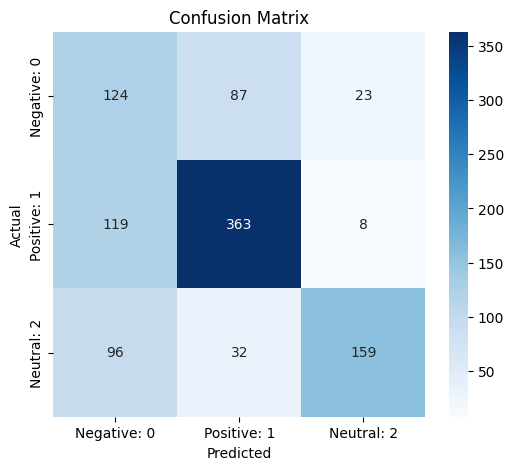

In [175]:
class_names = ["Negative: 0", "Positive: 1", "Neutral: 2"]
cm = confusion_matrix(y_test_labels, y_pred)

# Plot: Confusion Matrix
# Insight: Model is able to predict class 1 accuratly

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


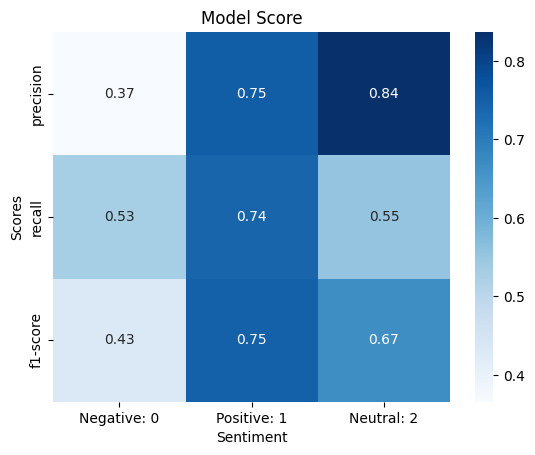

In [174]:
report = classification_report(y_test_labels, y_pred, output_dict=True, target_names=class_names)
report_df = pd.DataFrame(report)
prf = report_df.iloc[:3,:3]

# Plot: Precision Recall F1 score
# Insight: Model predicted class 1 Best
sns.heatmap(prf, cmap='Blues', annot=True, fmt=".2")
plt.ylabel('Scores')
plt.xlabel('Sentiment')
plt.title('Model Score')
plt.show()


# 7. Prediction on Unseen Text

In [167]:
# Find Sentiment
def sentiment(text):
  cleaned_text = clean_text(text)
  seq = tokenizer.texts_to_sequences([cleaned_text])
  seq = pad_sequences(seq, maxlen=max_len, padding="post")
  pred = model.predict(seq)
  sent_score = pred.argmax(axis=1)[0]
  result_df = pd.DataFrame({
    "text": [text],
    "sentiment score": [sent_score],
    "sentiment": [get_sent_label(sent_score)]
  })
  return result_df

In [168]:
sentiment("this product is bad")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


,text,sentiment score,sentiment
0,this product is bad,0,Negative


In [170]:
sentiment("The ride was so awesome!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


,text,sentiment score,sentiment
0,The ride was so awesome!,1,Positive


In [171]:
sentiment("I don't know what it eat toninght")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


,text,sentiment score,sentiment
0,I don't know what it eat toninght,2,Neutral


#🔎 Conclusion

In this project, I built a text classification model to classify reviews into Negative, Positive, and Neutral categories. The dataset consisted of ~4000 text samples, which is relatively small for NLP tasks, yet the model achieved:

- Accuracy: ~64%
- Macro F1-Score: ~0.62
- Weighted F1-Score: ~0.65

📊 From the evaluation metrics and plots:

The model performs well on Positive reviews due to their higher frequency in the dataset.

Negative reviews are more challenging to classify, likely because of fewer samples and overlapping vocabulary with neutral texts.


✅ Key Takeaways:

More data and advanced models (e.g., BERT) could further improve performance.